# Decision trees

A decision tree is much like playing "Twenty Questions." A question is asked, and the answer reduces the possible results, leading to a new question. **CART** (Classification And Regression Tree) is a popular method for systematizing the idea.

Given samples $\bfx_1,\ldots,\bfx_n$ and labels $y_1,\ldots,y_n$, the immediate goal is to partition the samples into subsets whose labels are as uniform as possible. The process is then repeated recursively on the subsets. Defining a measurement of label uniformity is a key step. 

## Gini impurity

Let $S$ be a subset of the samples, given as a list of indices into the original set. Suppose there are $K$ unique labels, which we denote $1,2,\ldots,K$. Define

$$
p_k = \frac{1}{ |S| } \sum_{i\in S} \mathbb{1}_k(y_i),
$$

where $|S|$ is the number of elements in $S$ and $\mathbb{1}_k$ is the **indicator function**

$$
\mathbb{1}_k(t) = \begin{cases} 
  1, & \text{if } t=k, \\ 
  0, & \text{otherwise.}
  \end{cases}
$$

In words, $p_k$ is the proportion of samples in $S$ that have label $k$. Then the **Gini impurity** is defined as 

$$
H(S) = \sum_{k=1}^K p_k(1-p_k).
$$

If one of the $p_k$ is 1, then the others are all zero and $H(S)=0$. This is considered optimal. At the other extreme, if $p_k=1/K$ for all $k$, then 

$$
H(S) = \sum_{k=1}^K \frac{1}{K} \left(1 - \frac{1}{K} \right) = K\cdot \frac{1}{K}\cdot\frac{K-1}{K} = \frac{K-1}{K} < 1.
$$

::::{prf:example}
:label: example-decision-trees-gini
Suppose a set $S$ has $n$ members with label 1, 1 member with label 2, and 1 member with label 3. What is the Gini impurity of $S$?

:::{dropdown} Solution
We have $p_1=n/(n+2)$, $p_2=p_3=1/(n+2)$. Hence

$$
H(S) &= \frac{n}{n+2}\left( 1 - \frac{n}{n+2} \right) + 2 \frac{1}{n+2}\left( 1 - \frac{1}{n+2} \right) \\ 
&= \frac{n}{n+2}\frac{2}{n+2} + \frac{2}{n+2}\frac{n+1}{n+2} \\ 
&= \frac{4n+2}{(n+2)^2}.
$$

This value is 1/2 for $n=0$ and approaches zero as $n\to\infty$.
:::
::::

## Partitioning

Now we can describe the partition process. If $j$ is a dimension (feature) number and $\theta$ is a numerical threshold, then the sample set can be partitioned into complementary sets $S_L$, in which $x_j \le \theta$, and $S_R$, in which $x_j > \theta$. Define the **total impurity** of the partition to be 

$$
Q(j,\theta) = \lvert S\rvert\, H(S) + \lvert T \rvert \, H(T).
$$

Choose the $(j,\theta)$ that minimize $Q$, and then recursively partition $S$ and $T$.

::::{prf:example}
:label: example-decision-trees-partition

Suppose the 1D real samples $x_i=i$ for $i=0,1,2,3$ have labels A,B,A,B. What is the optimal partition?

:::{dropdown} Solution
There are three ways to partition them.

* $S=\{0\}$, $T=\{1,2,3\}$. We have $H(S)=0$ and $H(T)=(2/3)(1/3)+(1/3)(2/3)=4/9$. Hence the total impurity for this partition is $(1)(0) + (3)(4/9) = 4/3$.
* $S=\{0,1\}$, $T=\{2,3\}$. Then $H(S)=H(T)=2(1/2)(1/2)=1/2$, and the total impurity is $(2)(1/2)+(2)(1/2)=2$. 
* $S=\{0,1,2\}$, $T=\{3\}$. This arrangement is the same as the first case with $A↔B$.

The best partition threshold is $x\le 0$ (or $x\le 2$, which is equivalent).
:::
::::

## Toy example

We first create a toy dataset with 20 random points, with two subsets of 10 that are shifted left/right a bit.

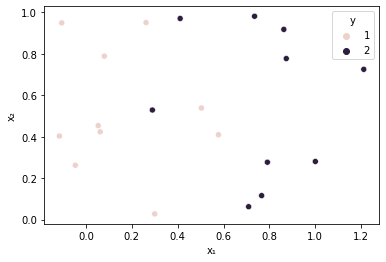

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(1)
x1 = rng.random((10,2))
x1[:,0] -= 0.25
x2 = rng.random((10,2))
x2[:,0] += 0.25
X = np.vstack((x1,x2))
y = np.hstack(([1]*10,[2]*10))

import seaborn as sns
df = pd.DataFrame({"x₁":X[:,0],"x₂":X[:,1],"y":y})
sns.scatterplot(data=df,x="x₁",y="x₂",hue="y");

Now we create a decision tree for these samples.

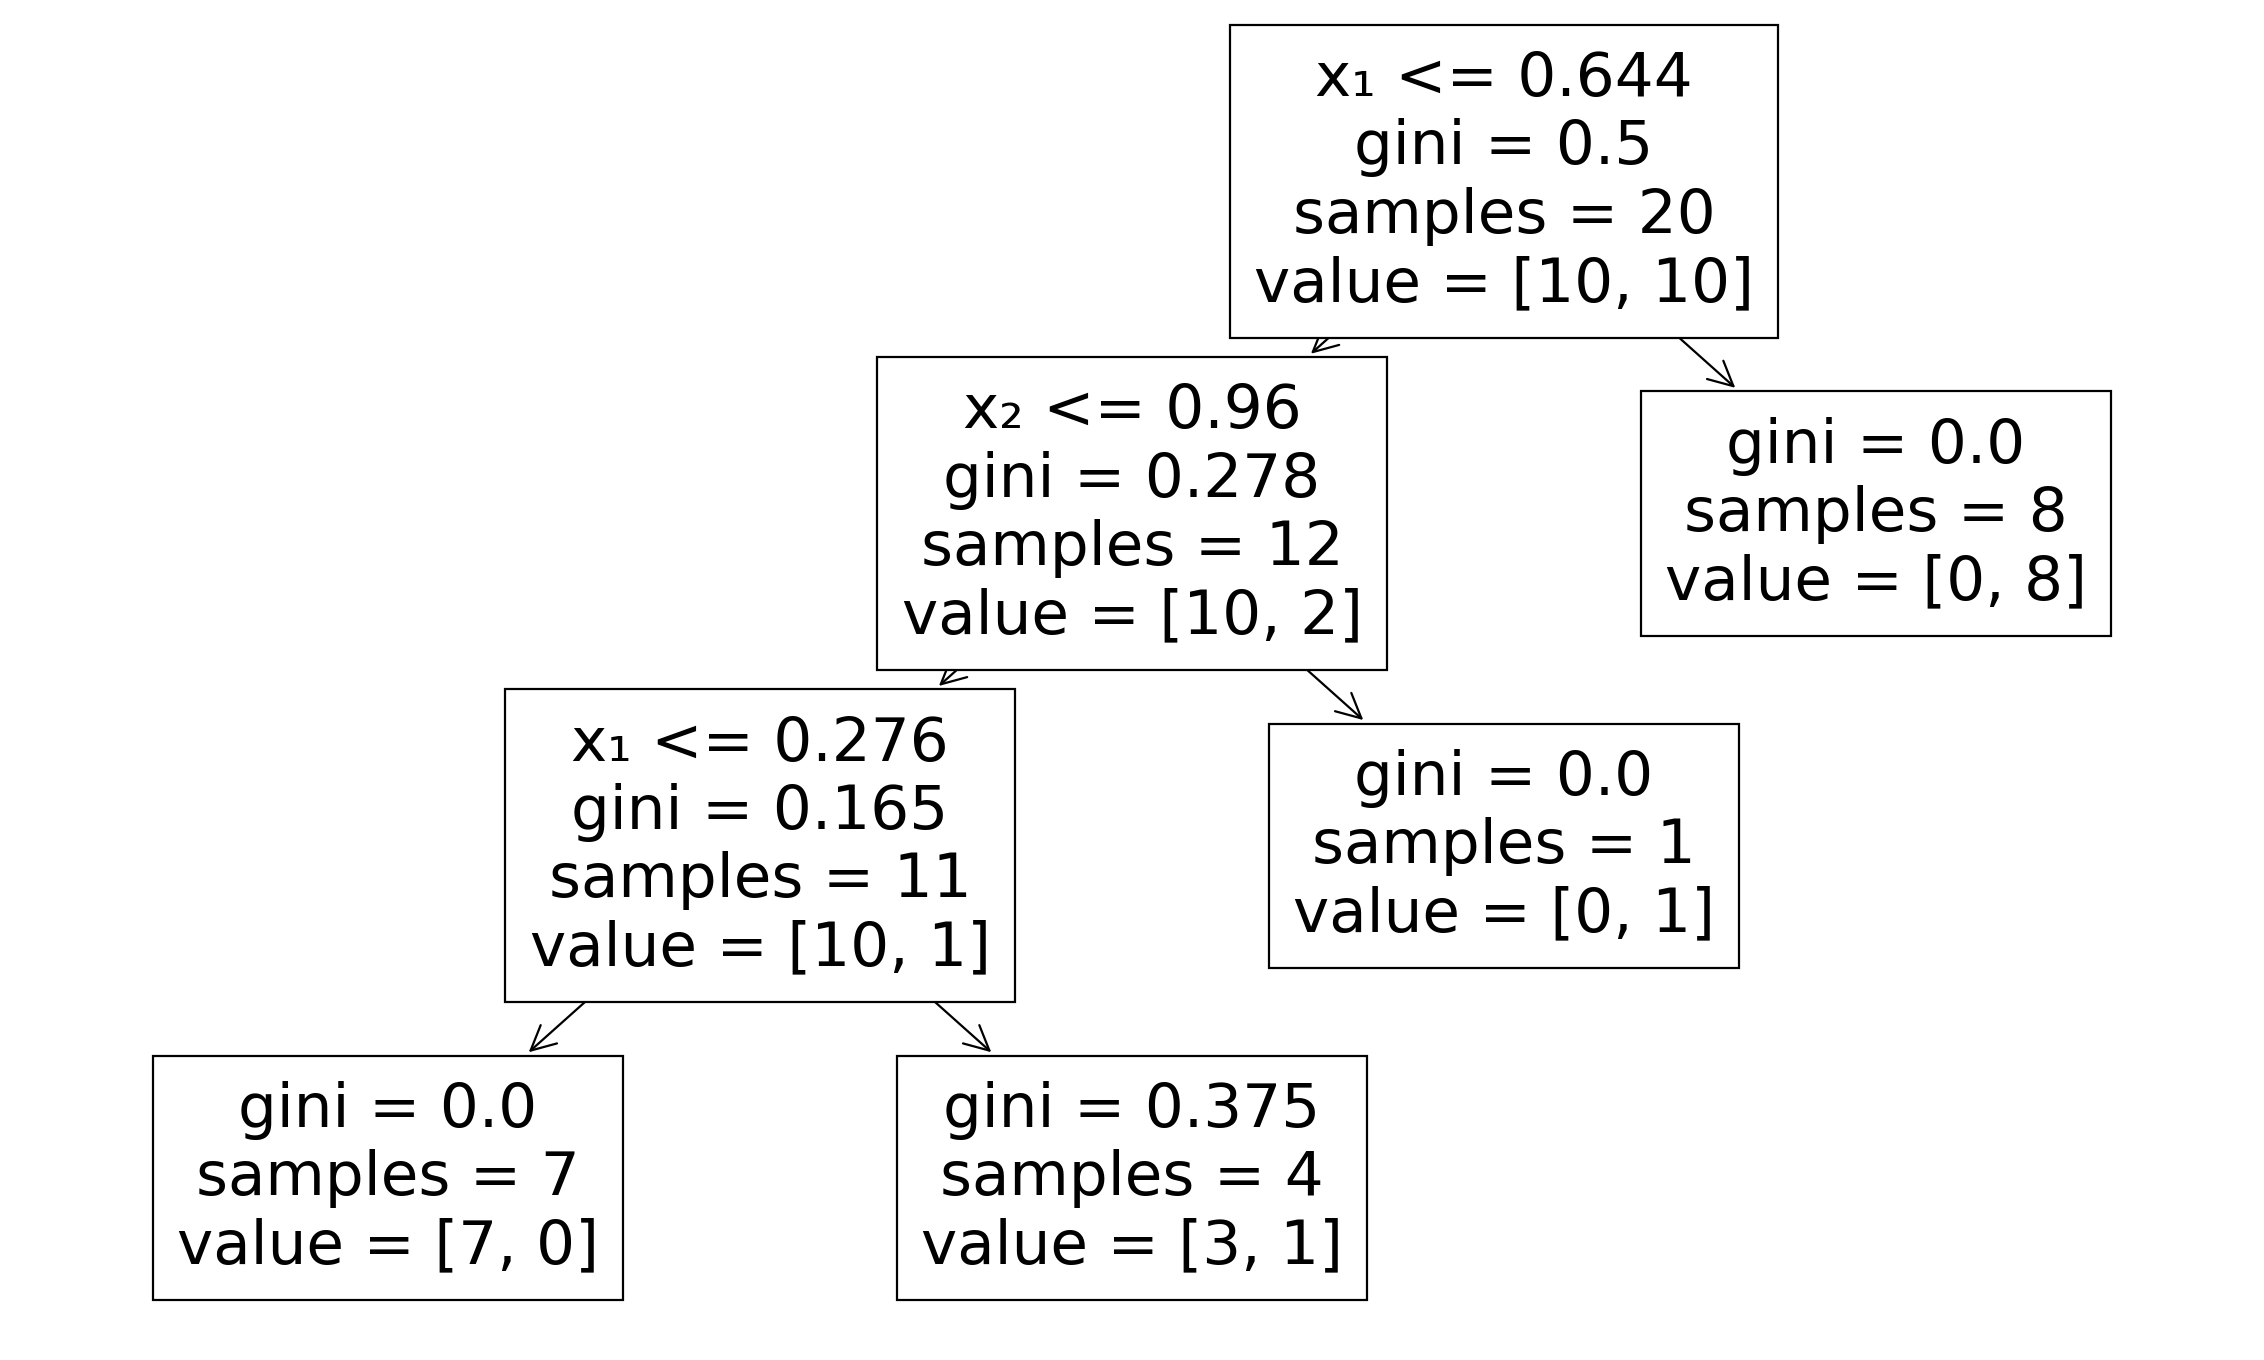

In [2]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
t = DecisionTreeClassifier(max_depth=3)
t.fit(X,y)

from matplotlib.pyplot import figure
figure(figsize=(18,11),dpi=160)
plot_tree(t,feature_names=["x₁","x₂"]);

The root of the tree (at the top) shows that the best split was found at the vertical line $x_1=0.644$. To the right of that line is a Gini value of zero: 8 samples, all with label 2. Thus, any future prediction by this tree will immediately return label 2 if the first feature of the input exceeds 0.644. Otherwise, it moves to the left child node and tests whether the second feature is greater than $0.96$. This splits along a horizontal line, above which there is a single sample with label 2. And so on.

Notice that the bottom right node has a nonzero Gini impurity. This node could be partitioned, but the classifier was constrained to stop at a depth of 3. If a prediction ends up here, then the classifier returns label 1, which is the most likely outcome.

Because we can follow the decision tree's logic step by step, we say it is highly **interpretable**. The transparency of the prediction algorithm is an attractive aspect of decision trees, although this advantage can weaken as the numbers of features and observations increase.

## Penguin data

We return to the penguins. There is no need to standardize the columns for a decision tree, because each feature is considered on its own.

In [3]:
import pandas as pd
pen = sns.load_dataset("penguins")
pen = pen.dropna()
X = pen[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]]
y = pen["species"]

We get some interesting information from looking at the top levels of a decision tree trained on the full dataset.

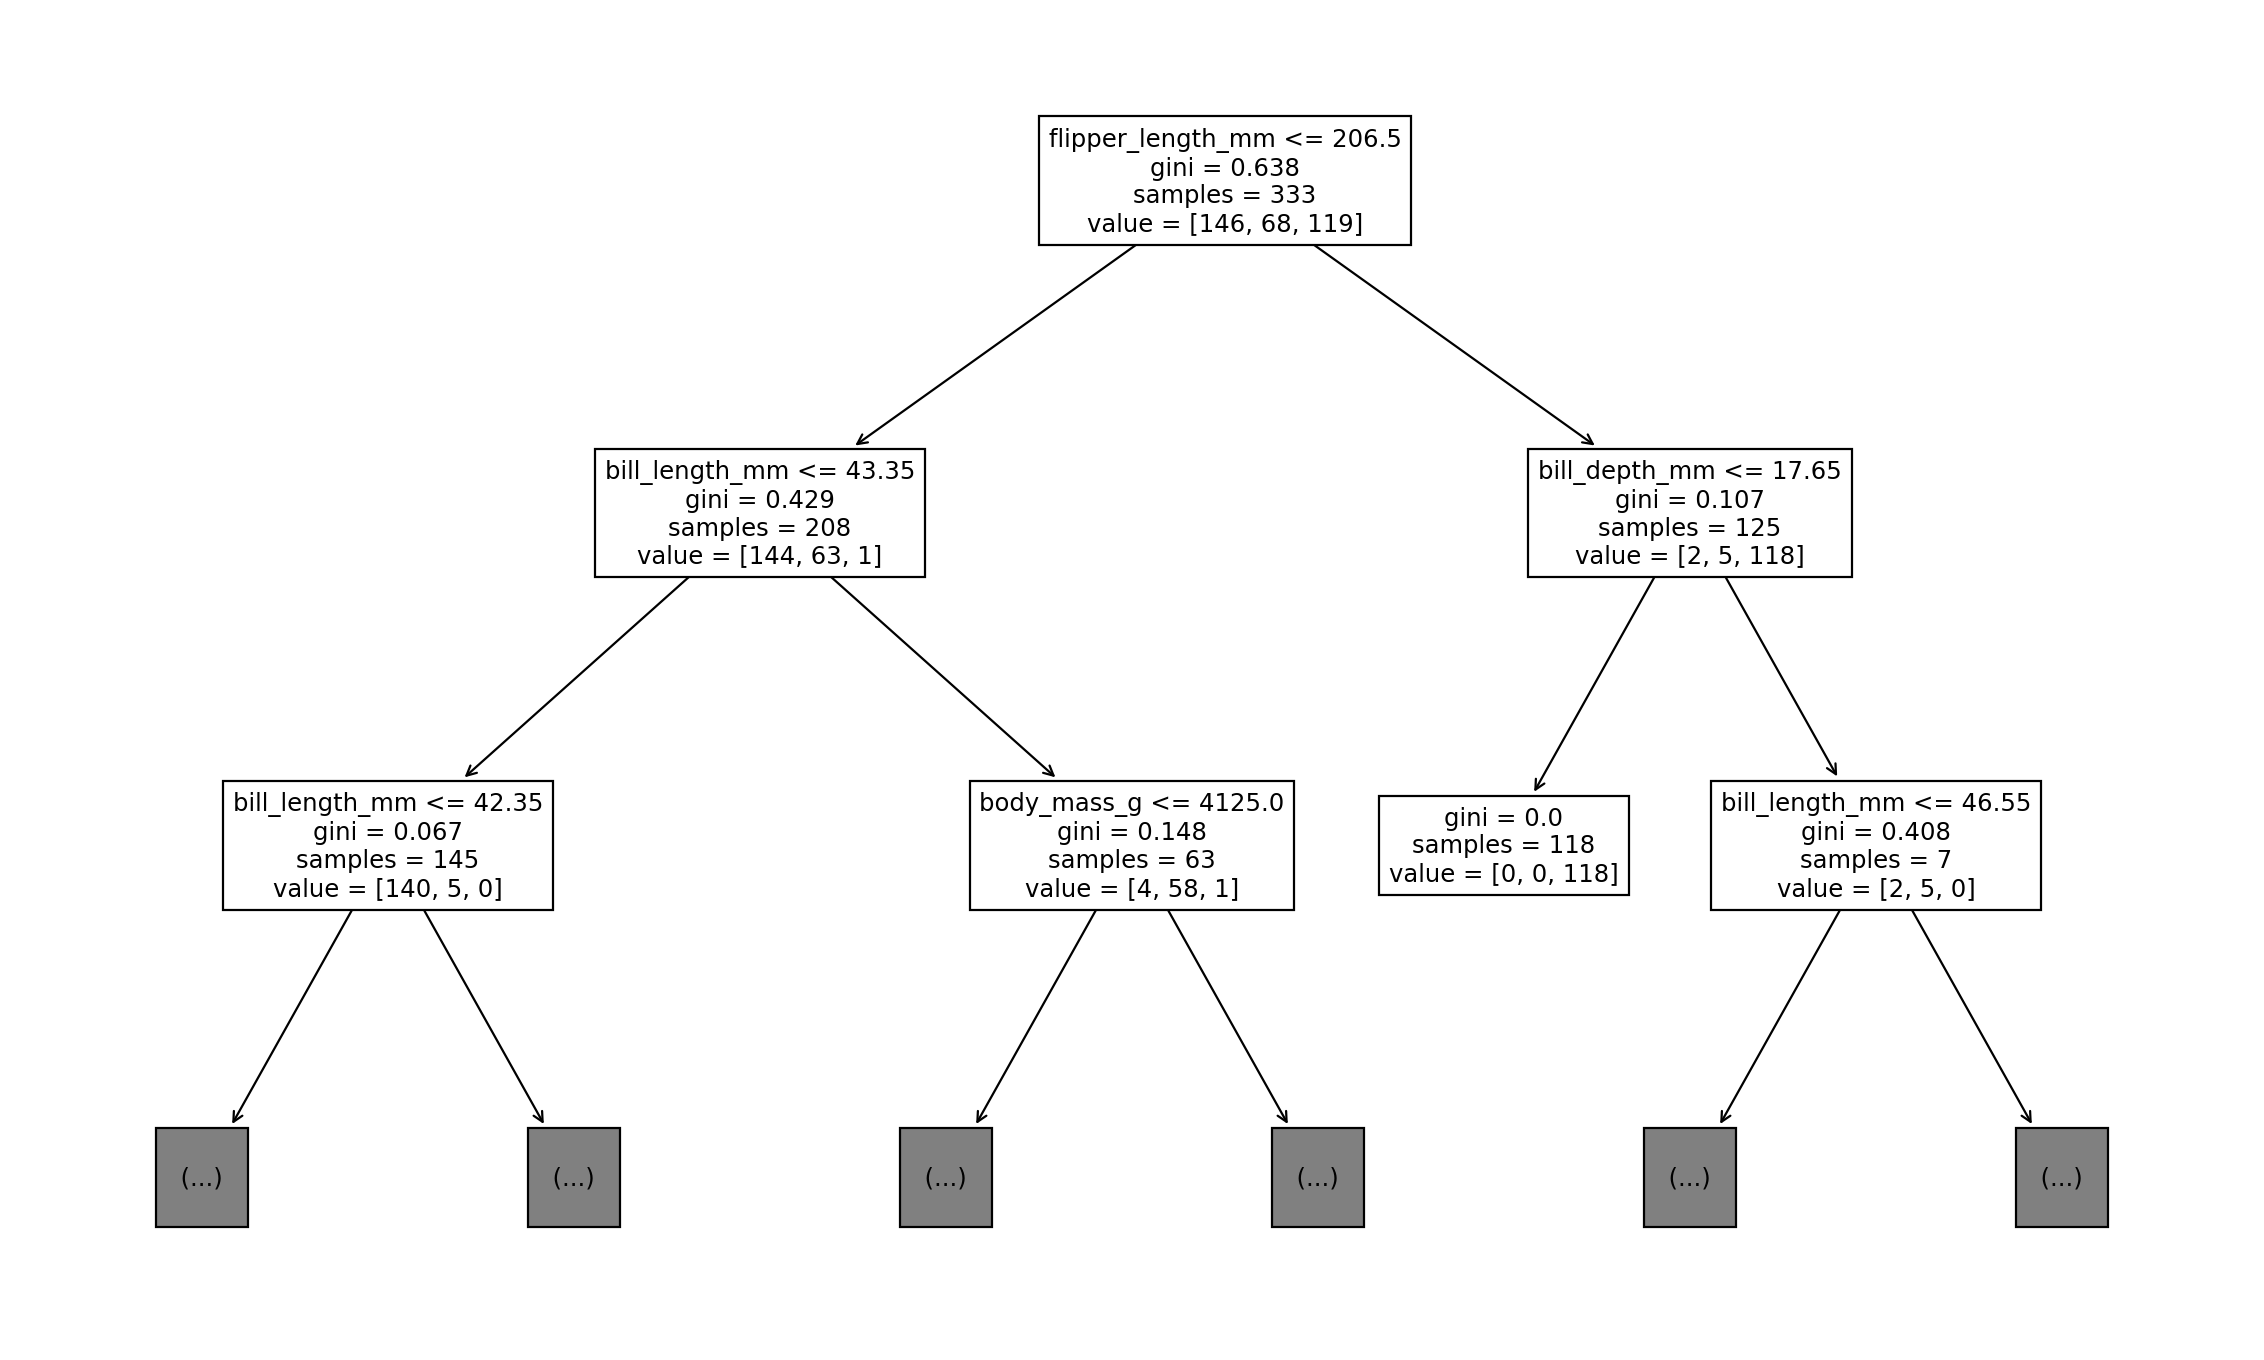

In [4]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X,y)

from matplotlib.pyplot import figure
figure(figsize=(18,11),dpi=160)
plot_tree(dt,max_depth=2,feature_names=X.columns);

The most determinative feature for identifying the species is the flipper length. If it exceeds 206.5 mm, then the penguin is rather likely to be a Gentoo. 

We can measure the relative importance of each feature by comparing their total contributions to reducing the Gini index. This is known as **Gini importance**.

In [5]:
pd.Series(dt.feature_importances_,index=X.columns)

bill_length_mm       0.381063
bill_depth_mm        0.051434
flipper_length_mm    0.553866
body_mass_g          0.013638
dtype: float64

Flipper length alone accounts for about half of the resolving power of the tree, followed in importance by the bill length. The other measurements apparently have little discriminative value.

In order to assess the effectiveness of the tree, we use the train–test paradigm.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)
dt.fit(X_tr,y_tr)

yhat = dt.predict(X_te)
print(confusion_matrix(y_te,yhat))
print(classification_report(y_te,yhat))


[[39  0  0]
 [ 2  8  0]
 [ 1  0 17]]
              precision    recall  f1-score   support

      Adelie       0.93      1.00      0.96        39
   Chinstrap       1.00      0.80      0.89        10
      Gentoo       1.00      0.94      0.97        18

    accuracy                           0.96        67
   macro avg       0.98      0.91      0.94        67
weighted avg       0.96      0.96      0.95        67



The performance is quite good, although the Chinstrap case is hindered by the relatively low number of training examples:

In [7]:
y_tr.value_counts()

Adelie       107
Gentoo       101
Chinstrap     58
Name: species, dtype: int64

## Limitations

Decision trees depend sensitively on the sample locations. A tree trained on one data subset may not do well on a new set. A small change can completely rewrite large parts of the tree, which gives a caveat about interpretation. Also, the partition algorithm, which is *greedy* by doing the best thing at the moment, does not necessarily find a globally optimal tree, or even a nearby one. 

Here we see mediocre performance on the loan application data.

In [8]:
loans = pd.read_csv("loan_clean.csv")
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_tr,y_tr)
yhat = dt.predict(X_te)
print(confusion_matrix(y_te,yhat))
print(classification_report(y_te,yhat))

[[ 229  150]
 [  15 7550]]
              precision    recall  f1-score   support

       False       0.94      0.60      0.74       379
        True       0.98      1.00      0.99      7565

    accuracy                           0.98      7944
   macro avg       0.96      0.80      0.86      7944
weighted avg       0.98      0.98      0.98      7944



To deal with these issues and more, you can try a **random forest**, which consists of many trees trained on subsets of the original features and datasets.

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,max_features=6)
rf.fit(X_tr,y_tr)

yhat = rf.predict(X_te)
print(confusion_matrix(y_te,yhat))

[[ 320   59]
 [   8 7557]]


The details of random forests are beyond our scope.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_bodwa4gl&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_tbpg3xa8" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>